In [1]:
!pip install Cmake

In [2]:
!pip install tensorflow opencv-python albumentations matplotlib

In [3]:
!pip install tensorflow-cpu

In [4]:
import tensorflow as tf
import numpy as np
import cv2
import os
import json
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [5]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [ ]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [8]:
import albumentations as alb

In [9]:
augmentor = alb.Compose([alb.RandomCrop(width=1500, height=1500),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.VerticalFlip(p=0.5),
                        alb.RGBShift(p=0.2)],
                       bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [6]:
img = cv2.imread(os.path.join('data','train', 'images', '1685344291041.jpg'))

In [7]:
with open(os.path.join('data','train','labels', '1685344291041.json'), 'r') as f:
    label = json.load(f)

In [8]:
label['shapes'][0]['points']

[[465.2380952380952, 1074.8571428571427],
 [1755.7142857142856, 2898.6666666666665]]

In [9]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [10]:
img.shape

(3264, 1840, 3)

In [11]:
coords = list(np.divide(coords, [1840, 3264, 1840, 3264]))

In [12]:
coords

[0.2528467908902691,
 0.32930672268907557,
 0.9541925465838509,
 0.8880718954248366]

In [26]:
image = img

# Bounding box coordinates
x, y, w, h = int(coords[0] * image.shape[1]), int(coords[1] * image.shape[0]), int(coords[2] * image.shape[1]), int(coords[3] * image.shape[0])

# Calculate ROI coordinates for the forehead area
roi_x_forehead = int(x + w * 0.1)
roi_y_forehead = int(y + h * 0.07)
roi_w_forehead = int(w * 0.5)
roi_h_forehead = int(h * 0.08) 

# Crop the ROI for the forehead area
roi_forehead = image[roi_y_forehead:roi_y_forehead+roi_h_forehead, roi_x_forehead:roi_x_forehead+roi_w_forehead]

# Calculate ROI coordinates for the left cheek area
roi_x_left_cheek = int(x + w * 0.04)
roi_y_left_cheek = int(y + h * 0.29)
roi_w_left_cheek = int(w * 0.2)
roi_h_left_cheek = int(h * 0.13) 

# Crop the ROI for the left cheek area
roi_left_cheek = image[roi_y_left_cheek:roi_y_left_cheek+roi_h_left_cheek, roi_x_left_cheek:roi_x_left_cheek+roi_w_left_cheek]

# Calculate ROI coordinates for the right cheek area
roi_x_right_cheek = int(x + w * 0.47)
roi_y_right_cheek = int(y + h * 0.3)
roi_w_right_cheek = int(w * 0.2)
roi_h_right_cheek = int(h * 0.13) 

# Crop the ROI for the right cheek area
roi_right_cheek = image[roi_y_right_cheek:roi_y_right_cheek+roi_h_right_cheek, roi_x_right_cheek:roi_x_right_cheek+roi_w_right_cheek]

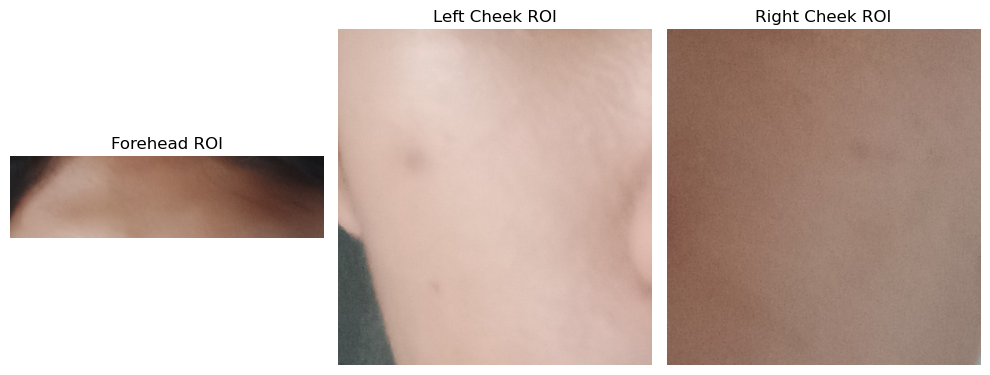

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(cv2.cvtColor(roi_forehead, cv2.COLOR_BGR2RGB))
axes[0].axis('off')
axes[0].set_title('Forehead ROI')

axes[1].imshow(cv2.cvtColor(roi_left_cheek, cv2.COLOR_BGR2RGB))
axes[1].axis('off')
axes[1].set_title('Left Cheek ROI')

axes[2].imshow(cv2.cvtColor(roi_right_cheek, cv2.COLOR_BGR2RGB))
axes[2].axis('off')
axes[2].set_title('Right Cheek ROI')

plt.tight_layout()
plt.show()

In [ ]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [ ]:
augmented['image'].shape

In [ ]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [1500, 1500]).astype(int)),
                tuple(np.multiply(augmented['bboxes'][0][2:], [1500, 1500]).astype(int)),
                        (0,255,0), 3)
plt.imshow(augmented['image'])

In [ ]:
for partition in ['train', 'val', 'test']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1840, 3264, 1840, 3264]))
            
        try:
            for x in range(50):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])
                
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0
                    
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)
        except Exception as e:
            print(e)

In [29]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda img: tf.image.resize(img, (120,120)))
train_images = train_images.map(lambda img: img/255)

In [30]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda img: tf.image.resize(img, (120,120)))
val_images = val_images.map(lambda img: img/255)

In [31]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda img: tf.image.resize(img, (120,120)))
test_images = test_images.map(lambda img: img/255)

In [32]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = 'utf-8') as f:
        label = json.load(f)
    return [label['class']], label['bbox']

In [33]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda lbl: tf.py_function(load_labels, [lbl], [tf.uint8, tf.float16]))

In [34]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda lbl: tf.py_function(load_labels, [lbl], [tf.uint8, tf.float16]))

In [35]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda lbl: tf.py_function(load_labels, [lbl], [tf.uint8, tf.float16]))

#  Combine Label and Image Samples

In [36]:
len(train_images), len(val_images), len(test_images)

(3950, 500, 500)

In [37]:
train = tf.data.Dataset.zip((train_images, train_labels)).shuffle(6000).batch(8).prefetch(4)

In [38]:
val = tf.data.Dataset.zip((val_images, val_labels)).shuffle(1000).batch(8).prefetch(4)

In [39]:
test = tf.data.Dataset.zip((test_images, test_labels)).shuffle(1000).batch(8).prefetch(4)

In [17]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [18]:
data_samples = train.as_numpy_iterator()

In [21]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


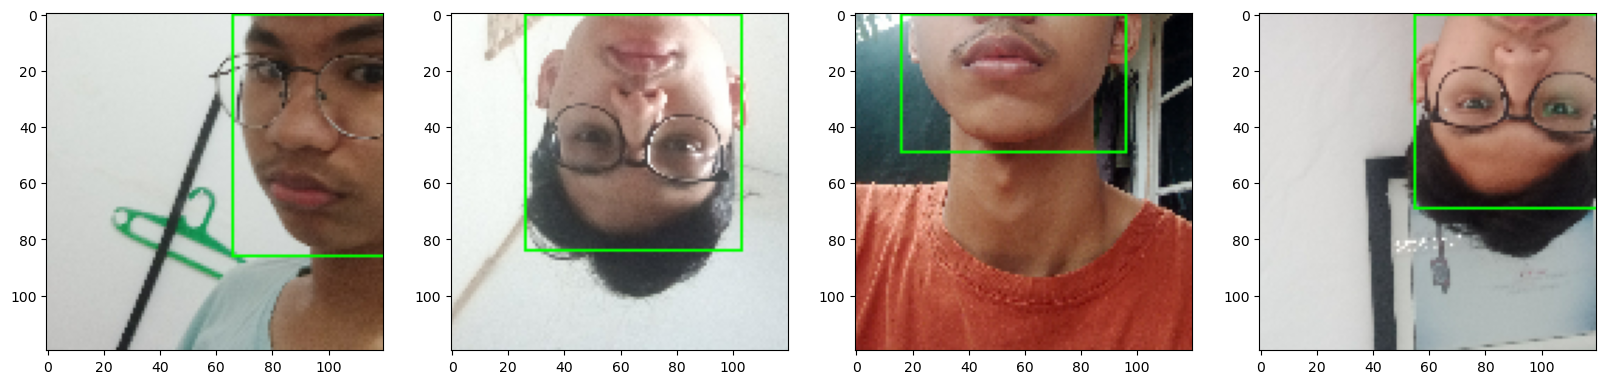

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    sample_image = res[0][i]
    sample_coords = res[1][1][i]
    
    cv2.rectangle(sample_image,
                 tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                 tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                 (0,255,0), 1)
    
    ax[i].imshow(sample_image)

# Neural Network

In [40]:
vgg = tf.keras.applications.VGG16(include_top=False)

In [41]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [42]:
def build_model():
    input_layer = tf.keras.layers.Input(shape=(120,120,3))
    
    vgg = tf.keras.applications.VGG16(include_top=False)(input_layer)
    
    f1 = tf.keras.layers.GlobalMaxPooling2D()(vgg)
    clas_1 = tf.keras.layers.Dense(2048, activation='relu')(f1)
    clas_2 = tf.keras.layers.Dense(1, activation='sigmoid')(clas_1)
    
    f2 = tf.keras.layers.GlobalMaxPooling2D()(vgg)
    reg_1 = tf.keras.layers.Dense(2048, activation='relu')(f2)
    reg_2 = tf.keras.layers.Dense(4, activation='sigmoid')(reg_1)
    
    facedetector = tf.keras.models.Model(inputs=input_layer, outputs=[clas_2, reg_2])
    return facedetector

In [43]:
facedetector = build_model()

In [44]:
facedetector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [50]:
X, y = train.as_numpy_iterator().next()

In [51]:
X.shape

(8, 120, 120, 3)

In [52]:
classes, coords = facedetector.predict(X)

1/1 [==============================] - 5s 5s/step


In [53]:
classes, coords

(array([[0.4067814 ],
        [0.47841033],
        [0.48067078],
        [0.5001516 ],
        [0.34672287],
        [0.39775568],
        [0.3892033 ],
        [0.42517623]], dtype=float32),
 array([[0.5331274 , 0.5029625 , 0.5927178 , 0.49590725],
        [0.6028225 , 0.5849395 , 0.6940572 , 0.514321  ],
        [0.6661214 , 0.61444145, 0.62112105, 0.5205159 ],
        [0.5447617 , 0.6028328 , 0.70754004, 0.5255037 ],
        [0.5304034 , 0.5985768 , 0.70401734, 0.49988604],
        [0.59469444, 0.6461386 , 0.66825473, 0.54098135],
        [0.6254271 , 0.5634121 , 0.689474  , 0.48983517],
        [0.6211944 , 0.6162217 , 0.67351717, 0.559845  ]], dtype=float32))

# Losses and Optimizers

In [54]:
batch = len(train)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=(1./0.75-1)/batch)

In [55]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [56]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true-w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [57]:
clasLoss = tf.keras.losses.BinaryCrossentropy()
regLoss = localization_loss

In [58]:
regLoss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=10.137745>

In [59]:
clasLoss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8081182>

# Train Neural Network

In [60]:
class FaceDetector(tf.keras.models.Model):
    def __init__(self, facedetector, **kwargs):
        super().__init__(**kwargs)
        self.model = facedetector
    
    def compile(self, optimizer, clasLoss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = clasLoss
        self.lloss = localizationloss
        self.optimizer = optimizer
        
    def train_step(self, batch, **kwargs):
        
        X, y = batch
        
        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localloss + 0.5 * batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        optimizer.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localloss}
    
    def test_step(self, batch, **kwargs):
        X, y = batch
        
        classes, coords = self. model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localloss = self.lloss(tf.cast(y[1], tf.float32), coords)    
        total_loss = batch_localloss+0.5*batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)
    
    def extractROI(self, img, coords, **kwargs):
        image = img

        if image is None:
            print("Failed to load the image:", img)
            return None

        x, y, w, h = int(coords[0] * image.shape[1]), int(coords[1] * image.shape[0]), int(coords[2] * image.shape[1]), int(coords[3] * image.shape[0])

        # Calculate ROI coordinates for the forehead area
        roi_x_forehead = int(x + w * 0.1)
        roi_y_forehead = int(y + h * 0.07)
        roi_w_forehead = int(w * 0.5)
        roi_h_forehead = int(h * 0.08) 

        # Crop the ROI for the forehead area
        roi_forehead = image[roi_y_forehead:roi_y_forehead+roi_h_forehead, roi_x_forehead:roi_x_forehead+roi_w_forehead]

        # Calculate ROI coordinates for the left cheek area
        roi_x_left_cheek = int(x + w * 0.04)
        roi_y_left_cheek = int(y + h * 0.29)
        roi_w_left_cheek = int(w * 0.2)
        roi_h_left_cheek = int(h * 0.13) 

        # Crop the ROI for the left cheek area
        roi_left_cheek = image[roi_y_left_cheek:roi_y_left_cheek+roi_h_left_cheek, roi_x_left_cheek:roi_x_left_cheek+roi_w_left_cheek]

        # Calculate ROI coordinates for the right cheek area
        roi_x_right_cheek = int(x + w * 0.47)
        roi_y_right_cheek = int(y + h * 0.3)
        roi_w_right_cheek = int(w * 0.2)
        roi_h_right_cheek = int(h * 0.13) 

        # Crop the ROI for the right cheek area
        roi_right_cheek = image[roi_y_right_cheek:roi_y_right_cheek+roi_h_right_cheek, roi_x_right_cheek:roi_x_right_cheek+roi_w_right_cheek]

        return roi_forehead, roi_left_cheek, roi_right_cheek

In [61]:
model = FaceDetector(facedetector)

In [62]:
model.compile(optimizer, clasLoss, regLoss)

In [63]:
history = model.fit(train.take(5), epochs=10, validation_data=val, callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logdir')])

Epoch 1/10
5/5 [==============================] - 463s 91s/step - total_loss: 4.4338 - class_loss: 0.6017 - regress_loss: 4.1329 - val_total_loss: 1.4251 - val_class_loss: 0.3140 - val_regress_loss: 1.2681
Epoch 2/10
5/5 [==============================] - 488s 95s/step - total_loss: 1.7359 - class_loss: 0.2949 - regress_loss: 1.5885 - val_total_loss: 3.0090 - val_class_loss: 1.5079 - val_regress_loss: 2.2550
Epoch 3/10
5/5 [==============================] - 506s 100s/step - total_loss: 2.5938 - class_loss: 0.3074 - regress_loss: 2.4400 - val_total_loss: 0.8790 - val_class_loss: 0.1256 - val_regress_loss: 0.8162
Epoch 4/10
5/5 [==============================] - 489s 92s/step - total_loss: 2.0551 - class_loss: 0.1720 - regress_loss: 1.9691 - val_total_loss: 0.6124 - val_class_loss: 0.0628 - val_regress_loss: 0.5810
Epoch 5/10
5/5 [==============================] - 485s 94s/step - total_loss: 1.1455 - class_loss: 0.1132 - regress_loss: 1.0889 - val_total_loss: 0.9459 - val_class_loss: 0.5

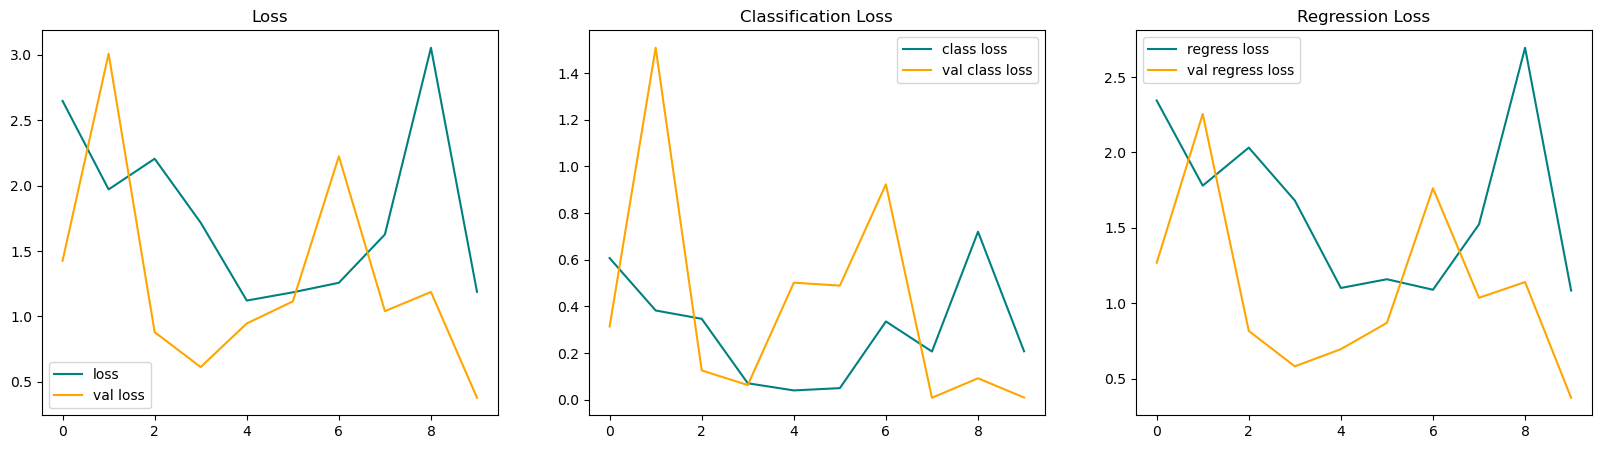

In [64]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(history.history['total_loss'], color='teal', label='loss')
ax[0].plot(history.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(history.history['class_loss'], color='teal', label='class loss')
ax[1].plot(history.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(history.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(history.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [65]:
test_data = test.as_numpy_iterator()

In [104]:
test_sample = test_data.next()

In [105]:
yhat = facedetector.predict(test_sample[0])

1/1 [==============================] - 4s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


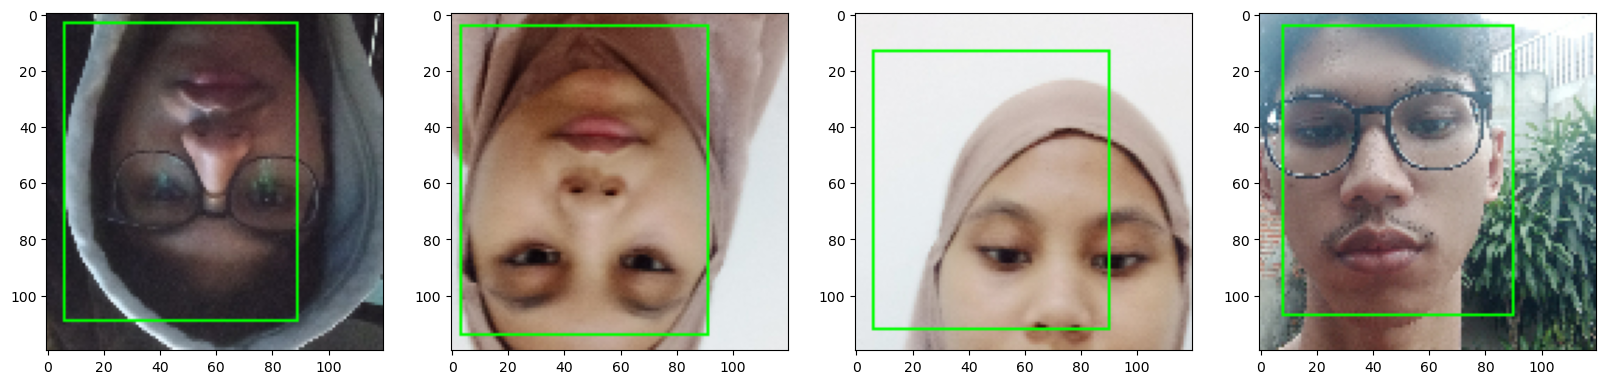

In [106]:
fig, ax= plt.subplots(ncols=4, figsize=(20,20))
for i in range(4):
    sample_image = test_sample[0][i]
    sample_coords = yhat[1][i]
    
    if yhat[0][i] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                       tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (0,255,0), 1)
        
    ax[i].imshow(sample_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


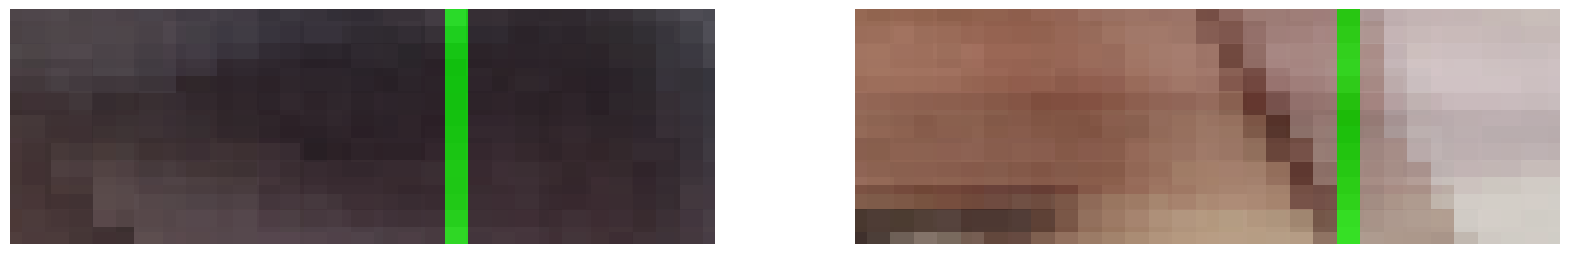

In [125]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
for i in range(2):
    sample_image = test_sample[0][i]
    sample_coords = yhat[1][i]
    
    if yhat[0][i] > 0.5:
        roi_forehead, roi_left_cheek, roi_right_cheek = model.extractROI(sample_image, sample_coords)
        
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                      (0, 255, 0), 1)
        
        ax[i].imshow(sample_image)
        ax[i].axis('off')
        #ax[i].set_title('Sample ' + str(i+1))
        #ax[i].text(10, 20, 'Forehead', color='red')
        #ax[i].text(10, 80, 'Left Cheek', color='red')
        #ax[i].text(70, 80, 'Right Cheek', color='red')
        ax[i].imshow(roi_forehead, extent=(10, 100, 30, 50), alpha=0.3)
        ax[i].imshow(roi_left_cheek, extent=(10, 40, 90, 100), alpha=0.3)
        ax[i].imshow(roi_right_cheek, extent=(70, 100, 90, 100), alpha=0.3)
    else:
        ax[i].imshow(sample_image)
        ax[i].axis('off')
        ax[i].set_title('Sample ' + str(i+1) + ' (No Face Detected)')

In [ ]:
facedetector.save('facedetector.h5')

In [ ]:
facedetector = load_model('facedetector.h5')